
# Polynomial Regression — Intuition to Implementation

Welcome! In this tutorial, we'll explore **Polynomial Regression** step by step.

### Learning Objectives
By the end of this notebook, you will be able to:
- Understand the intuition behind polynomial regression.
- Generate and visualize synthetic datasets.
- Compare linear vs. polynomial regression models.
- Select the right polynomial degree using cross-validation.
- See the effect of **overfitting** and how **regularization** (Ridge, Lasso) helps.
- Evaluate models using metrics and plots.



## 1) Setup

We'll use `numpy`, `matplotlib`, and `scikit-learn`.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_diabetes

# For reproducibility
rng = np.random.default_rng(42)

# Matplotlib defaults (no specific colors/styles as a teaching baseline)
plt.rcParams.update({
    "figure.figsize": (6, 4),
})
print("Libraries imported successfully.")


Libraries imported successfully.


In [112]:
!pip install ipywidgets

In [111]:

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import ipywidgets as widgets
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')


## 2) What is Polynomial Regression? (Intuition)

**Regression** predicts a continuous value (e.g., price, temperature).  
**Linear regression** fits a straight line:  

$ y \approx \theta_0 + \theta_1 x $

But many relationships are curved. **Polynomial regression** fits:

$$
y \approx \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_d x^d
$$

It's **linear in parameters** (the $\theta$'s), but **nonlinear in the input** due to the feature transform:  

$ x \to [x, x^2, x^3, \dots, x^d] $


## 2.1) Why Do We Create Polynomial Features?

### When building models, our goal is always to provide the **most informative input features**.  
The model’s job becomes much easier if the inputs already contain the right transformations.

- If we only gave the raw $x$ (degree 1), then in theory a *sufficiently complex* model (like a deep neural net) could eventually learn the mapping $f(x)$.
- But if we **use domain knowledge** and add higher powers ($x^2, x^3, \dots$), then even a **simpler linear model** can approximate the same function well.  
- In other words: *feature engineering reduces the burden on the model architecture*.

### Example

Suppose the true function is cubic:  

$$
f(x) = 0.5x^3 - 1.2x^2 + 0.9x + 2
$$

- If we only provide $x$, then a simple linear model can **never** capture the cubic shape.  
- But if we also provide $x^2$ and $x^3$, then **linear regression in these transformed features** is enough.

---

## 2.2) Informative vs. Redundant Features

Sometimes features are mathematically related. For example, $x$ and $x^3$ are dependent, since one is just a power of the other.  

But:
- In terms of information content, **$x^3$ is more useful** when the underlying function has cubic behavior.  
- During training, the algorithm still treats $x$ and $x^3$ as if they were independent features.  
- This is fine: what matters is whether the feature set allows a simple linear combination to capture the target function.

**Key idea:**  
Even though polynomial features are dependent, they *add expressive power* for linear models, letting us approximate nonlinear relationships without building a more complex architecture.



## 3) A Simple Synthetic Dataset

We'll create a 1D dataset where a straight line struggles, but a curved model does well.


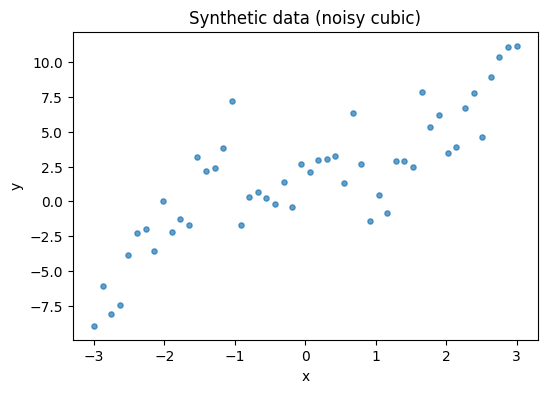

In [89]:

# Generate synthetic data from a noisy cubic curve
n = 50
X = np.linspace(-3, 3, n).reshape(-1, 1)
# true_fn = lambda x: 0.5*x**3 - 1.2*x**2 + 0.9*x + 2.0
true_fn = lambda x: 0.4*x**3+ 2.0
y_true = true_fn(X)
noise = rng.normal(0, 2.0, size=(n, 1))
y = (y_true + noise).ravel()

# Quick visualization
plt.scatter(X, y, s=14, alpha=0.7)
plt.title("Synthetic data (noisy cubic)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


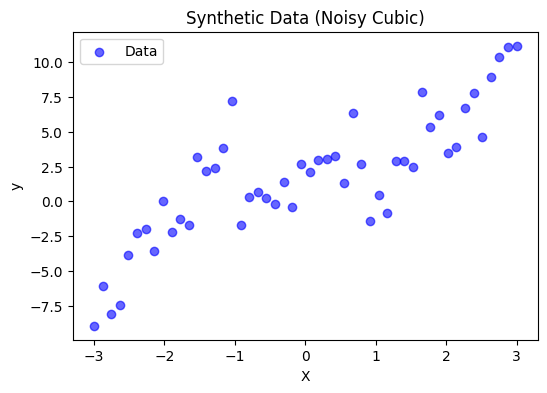

In [90]:

plt.figure(figsize=(6,4))
plt.scatter(X, y, color='blue', alpha=0.6, label="Data")
plt.title("Synthetic Data (Noisy Cubic)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


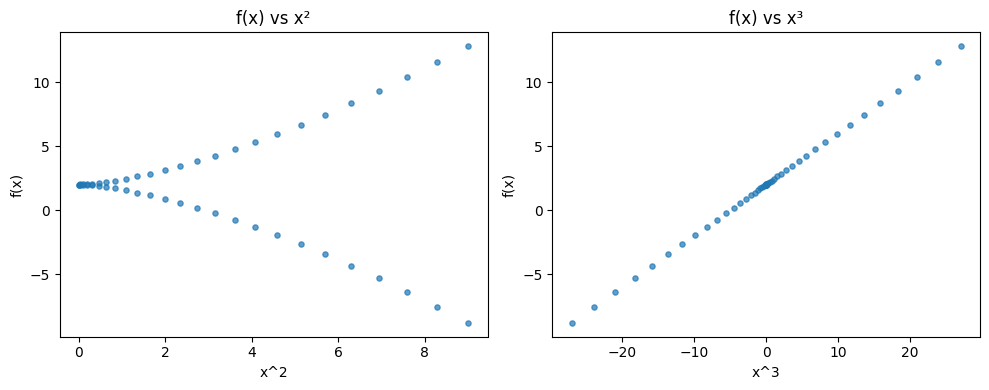

In [91]:
from mpl_toolkits.mplot3d import Axes3D

# Our function is cubic: f(x) = 0.5x^3 - 1.2x^2 + 0.9x + 2
# Let's look at different feature spaces

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Plot y vs x^2
axes[0].scatter(X**2, y_true, s=14, alpha=0.7)
axes[0].set_xlabel("x^2")
axes[0].set_ylabel("f(x)")
axes[0].set_title("f(x) vs x²")

# Plot y vs x^3
axes[1].scatter(X**3, y_true, s=14, alpha=0.7)
axes[1].set_xlabel("x^3")
axes[1].set_ylabel("f(x)")
axes[1].set_title("f(x) vs x³")

plt.tight_layout()
plt.show()



## 4) Linear Regression Baseline

Let's first fit a **straight line** and see how it performs.


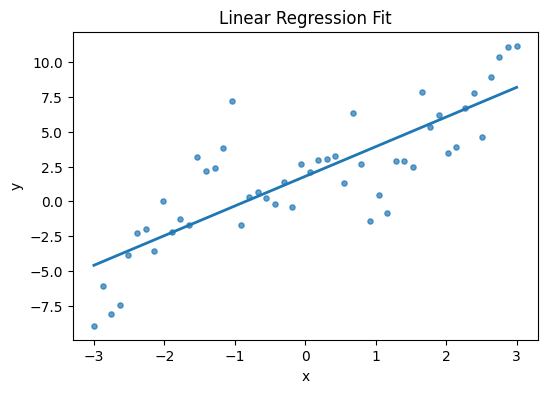

R^2 (on all data) = 0.6755790256432239
MSE (on all data) = 6.796059168584308


In [92]:

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Predictions for plotting
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_pred_lin = lin_reg.predict(X_plot)

plt.scatter(X, y, s=14, alpha=0.7)
plt.plot(X_plot, y_pred_lin, linewidth=2)
plt.title("Linear Regression Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print("R^2 (on all data) =", r2_score(y, lin_reg.predict(X)))
print("MSE (on all data) =", mean_squared_error(y, lin_reg.predict(X)))


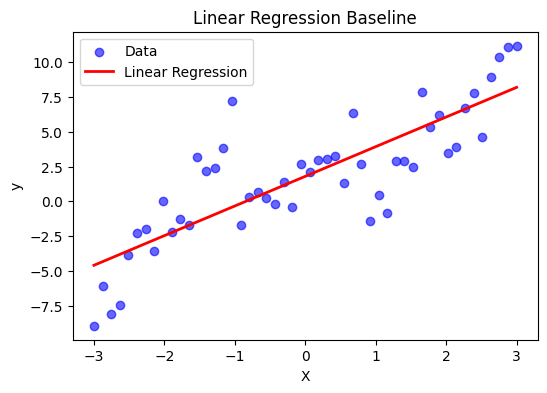

In [93]:

plt.figure(figsize=(6,4))
plt.scatter(X, y, color='blue', alpha=0.6, label="Data")
plt.plot(X, lin_reg.predict(X), color='red', linewidth=2, label="Linear Regression")
plt.title("Linear Regression Baseline")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()



## 5) Polynomial Regression: Different Degrees

We'll compare degrees **2**, **3**, and **10**.  
We'll use a `Pipeline` to chain `PolynomialFeatures` + `LinearRegression`.


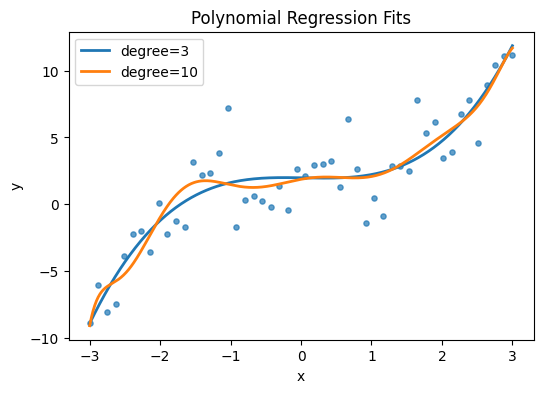

Degree  3 -> R^2=0.817 | MSE=3.838
Degree 10 -> R^2=0.827 | MSE=3.623


In [94]:

def poly_fit_predict(X, y, degree):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(X, y)
    return model, model.predict(X), model.predict(X_plot)

degrees = [3,10]
plt.scatter(X, y, s=14, alpha=0.7)
for d in degrees:
    model, y_hat, y_plot = poly_fit_predict(X, y, d)
    plt.plot(X_plot, y_plot, linewidth=2, label=f"degree={d}")
plt.title("Polynomial Regression Fits")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

for d in degrees:
    model, y_hat, _ = poly_fit_predict(X, y, d)
    print(f"Degree {d:2d} -> R^2={r2_score(y, y_hat):.3f} | MSE={mean_squared_error(y, y_hat):.3f}")


## What if we add *all possible features*?

What if we don’t stop at $x, x^2, x^3$ but include the first **50 powers of $x$**?

- In theory, the model becomes **very flexible**: with enough powers, it can fit almost any dataset.
- In practice, this leads to **overfitting**:
  - The model memorizes noise in the training data.
  - Predictions on new data (test set) become poor.
- Also, higher powers like $x^{20}, x^{50}$ often produce **huge values** (feature explosion), making training unstable.

This is why we **don’t blindly add all features**:
1. Use **domain knowledge** to guide which features are informative.  
2. Use **model selection (cross-validation)** to decide the best polynomial degree.  
3. Use **regularization (Ridge, Lasso)** to control complexity if many features are included.

Bottom line: **More features ≠ Better model**.  
We want the *right balance* between expressive features and generalization.


In [95]:

@interact(degree=widgets.IntSlider(min=1, max=20, step=1, value=3))
def plot_poly_fit(degree=3):
    X_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    poly_reg = Pipeline([("poly", PolynomialFeatures(degree=degree)),
                         ("lin_reg", LinearRegression())])
    poly_reg.fit(X, y)
    y_pred = poly_reg.predict(X_grid)
    
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, color='blue', alpha=0.5, label="Data")
    plt.plot(X_grid, y_pred, color='red', linewidth=2, label=f"Degree {degree}")
    plt.title(f"Polynomial Regression Fit (degree={degree})")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()


interactive(children=(IntSlider(value=3, description='degree', max=20, min=1), Output()), _dom_classes=('widge…


## 6) Train–Test Split & Picking the Degree

To understand **generalization**, we split data into train and test sets and evaluate on both.  
Overfitting shows up as **low train error** but **high test error**.


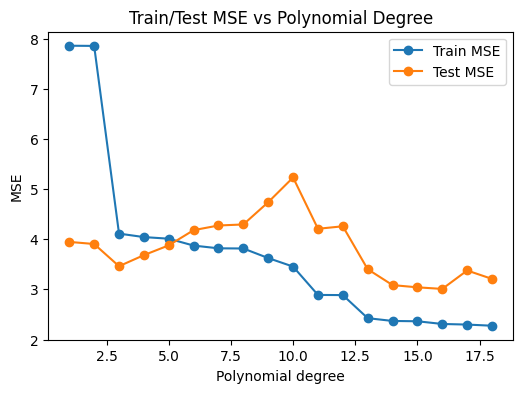

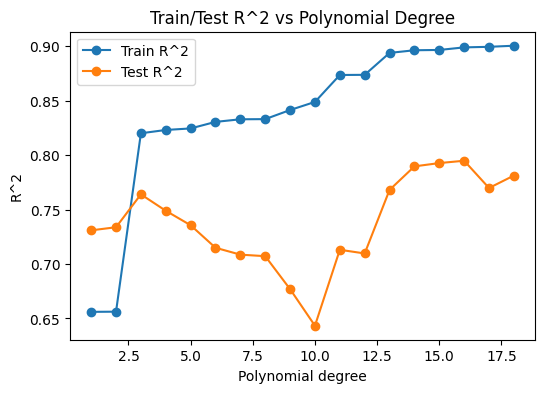

In [96]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

def evaluate_degrees(max_degree=15):
    train_mse = []
    test_mse = []
    train_r2 = []
    test_r2 = []
    degrees = range(1, max_degree+1)
    for d in degrees:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("lin", LinearRegression())
        ])
        model.fit(X_train, y_train)
        y_tr = model.predict(X_train)
        y_te = model.predict(X_test)
        train_mse.append(mean_squared_error(y_train, y_tr))
        test_mse.append(mean_squared_error(y_test, y_te))
        train_r2.append(r2_score(y_train, y_tr))
        test_r2.append(r2_score(y_test, y_te))
    return list(degrees), train_mse, test_mse, train_r2, test_r2

degrees_list, tr_mse, te_mse, tr_r2, te_r2 = evaluate_degrees(18)

# Plot MSE vs degree
plt.plot(degrees_list, tr_mse, marker="o", label="Train MSE")
plt.plot(degrees_list, te_mse, marker="o", label="Test MSE")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Train/Test MSE vs Polynomial Degree")
plt.legend()
plt.show()

# Plot R^2 vs degree
plt.plot(degrees_list, tr_r2, marker="o", label="Train R^2")
plt.plot(degrees_list, te_r2, marker="o", label="Test R^2")
plt.xlabel("Polynomial degree")
plt.ylabel("R^2")
plt.title("Train/Test R^2 vs Polynomial Degree")
plt.legend()
plt.show()



## 7) Cross-Validation for Degree Selection

We'll use K-fold cross-validation to pick the degree that best generalizes.


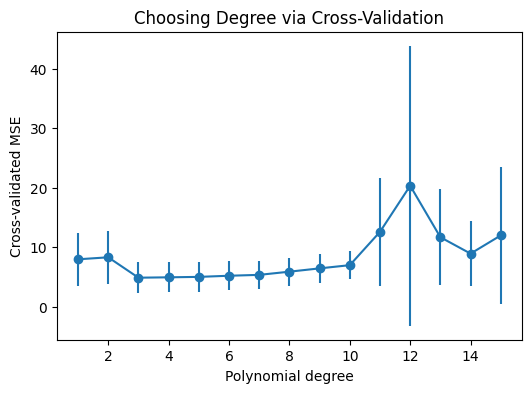

Best degree by CV (min MSE) = 3


In [97]:

def cv_score_for_degree(X, y, degree, cv=5):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    kf = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    return scores

degrees = range(1, 16)
mean_mse = []
std_mse = []
for d in degrees:
    scores = cv_score_for_degree(X, y, d, cv=5)  # negative MSE
    mean_mse.append(-scores.mean())
    std_mse.append(scores.std())

plt.errorbar(list(degrees), mean_mse, yerr=std_mse, marker="o")
plt.xlabel("Polynomial degree")
plt.ylabel("Cross-validated MSE")
plt.title("Choosing Degree via Cross-Validation")
plt.show()

best_d = list(degrees)[int(np.argmin(mean_mse))]
print("Best degree by CV (min MSE) =", best_d)


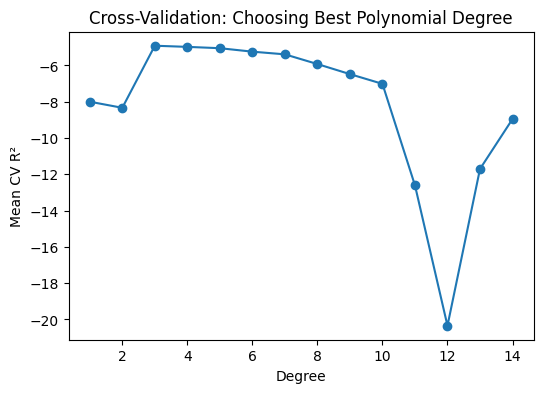

In [98]:

degrees = range(1, 15)
cv_scores = [np.mean(cv_score_for_degree(X, y, d)) for d in degrees]

plt.figure(figsize=(6,4))
plt.plot(degrees, cv_scores, marker='o')
plt.title("Cross-Validation: Choosing Best Polynomial Degree")
plt.xlabel("Degree")
plt.ylabel("Mean CV R²")
plt.show()


## 8) Regularization: Ridge & Lasso 

High-degree polynomials can **overfit**. Regularization shrinks coefficients to improve generalization.

- **Ridge** adds an $ \ell_2 $ penalty (squares of coefficients).
- **Lasso** adds an $ \ell_1 $ penalty (absolute values), encouraging sparsity.

We'll compare **unregularized LinearRegression** vs. **Ridge** vs. **Lasso** for degree 15.


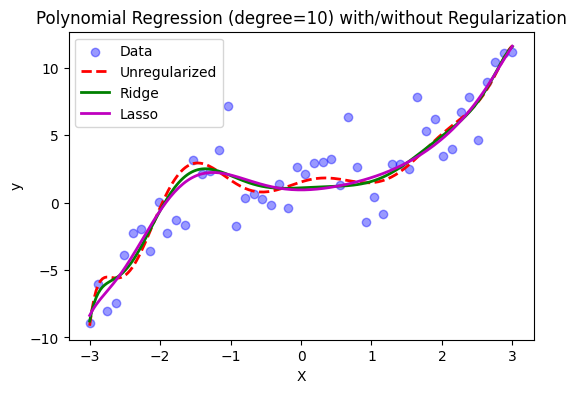

In [110]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

degree = 10

# Transform training data
X_poly = PolynomialFeatures(degree).fit_transform(X_train)

# Models
lin = LinearRegression()
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01, max_iter=20000)

# Fit models
lin.fit(X_poly, y_train)
ridge.fit(X_poly, y_train)
lasso.fit(X_poly, y_train)

# Grid for smooth plotting
X_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
X_grid_poly = PolynomialFeatures(degree).fit_transform(X_grid)

# Plot results
plt.figure(figsize=(6,4))
plt.scatter(X, y, color='blue', alpha=0.4, label="Data")
plt.plot(X_grid, lin.predict(X_grid_poly), "r--", linewidth=2, label="Unregularized")
plt.plot(X_grid, ridge.predict(X_grid_poly), "g-", linewidth=2, label="Ridge")
plt.plot(X_grid, lasso.predict(X_grid_poly), "m-", linewidth=2, label="Lasso")
plt.title(f"Polynomial Regression (degree={degree}) with/without Regularization")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


In [104]:

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return {
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Train R²": r2_score(y_train, y_pred_train),
        "Test R²": r2_score(y_test, y_pred_test),
    }

results = {}
for d in [1, 2, 3, 6, 12]:
    model = Pipeline([("poly", PolynomialFeatures(degree=d)),
                      ("lin_reg", LinearRegression())])
    model.fit(X_train, y_train)
    results[f"Degree {d}"] = evaluate_model(model, X_train, y_train, X_test, y_test)

results_df = pd.DataFrame(results).T
display(results_df)


,Train RMSE,Test RMSE,Train R²,Test R²
Degree 1,2.803418,1.986609,0.656073,0.730918
Degree 2,2.802754,1.976009,0.656236,0.733781
Degree 3,2.027791,1.860584,0.820056,0.763974
Degree 6,1.968032,2.044787,0.830506,0.714927
Degree 12,1.698770,2.063497,0.873713,0.709686



## ✅ Key Takeaways

- Linear regression struggles with non-linear patterns.  
- Polynomial regression allows flexibility but risks **overfitting** with high degrees.  
- Cross-validation helps us select the best degree.  
- **Regularization (Ridge, Lasso)** stabilizes high-degree models and reduces overfitting.  
- Always compare models on both **train** and **test** performance.  

👉 Polynomial regression is a **special case of linear regression**, where we expand the feature space using polynomial terms.
